### This notebook implements the controller covered in Section 4 of [1] considering the numerical example discussed in [2]. Here, we consider the case of C = I_n, i.e., the case of full-state feedback. The Python library for control systems used here is [3].

### References:
[1] Nersesov, S.G., Haddad, W.M. and Chellaboina, V., 2004. Optimal fixed‐structure control for linear non‐negative dynamical systems. International Journal of Robust and Nonlinear Control: IFAC‐Affiliated Journal, 14(5), pp.487-511.

[2] Zocco, F., Haddad, W.M. and Malvezzi, M., 2025. CarboNet: A finite-time combustion-tolerant compartmental network for tropospheric carbon control. arXiv preprint arXiv:2508.16774.

[3] Python control-systems library: https://python-control.readthedocs.io/en/latest/intro.html

In [ ]:
%pip install control

import control as ct
import numpy as np

import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
### Create a matrix A with random rate coefficients and satisfing the set-point condition 0 = Ax_e + Bv_e:

n_q = 15
n_h = 7
min_rate_constant = 1
max_rate_constant = 10

a_41 = np.random.uniform(min_rate_constant, max_rate_constant)
a_12 = np.random.uniform(min_rate_constant, max_rate_constant)
a_13 = np.random.uniform(min_rate_constant, max_rate_constant)
a_14 = np.random.uniform(min_rate_constant, max_rate_constant)
a_42 = np.random.uniform(min_rate_constant, max_rate_constant)
a_22 = np.random.uniform(min_rate_constant, max_rate_constant)
a_43 = np.random.uniform(min_rate_constant, max_rate_constant)
a_33 = np.random.uniform(min_rate_constant, max_rate_constant)

# Constraints from the set-point condition (0 = Ax_e + Bv_e):
if a_22 == n_q*(a_12 + a_42) or a_33 == n_h*(a_13 + a_43):
  print("Careful, pair (A, B) may not be stabilizable with these rates.")


A = np.array([[-a_41, n_q*a_12, n_h*a_13, a_14],
              [0, -n_q*(a_12+a_42)+a_22, 0, 0],
              [0, 0, -n_h*(a_13+a_43)+a_33, 0],
              [a_41, n_q*a_42, n_h*a_43, -a_14]])

B = np.array([[-1],
              [0],
              [0],
              [0]])


C = np.identity(4)

D = np.zeros((4,1))

sys = ct.ss(A, B, C, D) #create LTI system

print("A = ", A)
print("B = ", B)
print("C = ", C)
print("D = ", D)

A =  [[  -3.40742062   95.81610494   39.62507976    5.6353227 ]
 [   0.         -128.84605851    0.            0.        ]
 [   0.            0.          -95.19704966    0.        ]
 [   3.40742062   38.56915493   63.91448913   -5.6353227 ]]
B =  [[-1]
 [ 0]
 [ 0]
 [ 0]]
C =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
D =  [[0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
eigenvalues, _ = np.linalg.eig(A)
print("Eigenvalues of A:", eigenvalues)

Eigenvalues of A: [   0.           -9.04274332 -128.84605851  -95.19704966]


Now check the conditions required by the controller of Nersesov et al. [1], Section 4. IMPORTANT: This code assumes that A has 1 eigenvalue equal to 0 and the other eigenvalues have negative real parts, which is often the case with this definition of A. If this is not what you have, generate another A.

In [ ]:
# (1) (A, B) must be stabilizable
# (checked with the PBH rank test: rank[\sigma*I-A   B] = n  for all eigenvalues of A, namely, \sigma, such that Re(\sigma) >= 0)

PBHmatrixTest = np.c_[-A, B]
n, _ = A.shape
if np.linalg.matrix_rank(PBHmatrixTest) == n:
    print("The pair (A, B) is stabilizable")

The pair (A, B) is stabilizable


In [ ]:
# (2) There exists v_e such that 0 = Ax_e + Bv_e:

min_equilibrium = 0.5
max_equilibrium = 5

x1e = np.random.uniform(min_equilibrium, max_equilibrium)
v_e = 0 # see source paper [2] for the reason of this condition
x2e = 0 # see source paper [2] for the reason of this condition
x3e = 0 # see source paper [2] for the reason of this condition
x4e = (a_41/a_14)*x1e
xe = np.array([[x1e],
               [x2e],
               [x3e],
               [x4e]])

In [ ]:
# (3) (A, R_1) is observable      NOTE: R_1 is a control design matrix (i.e., it is chosen)
R_1 = np.identity(n)
Obs_matrix = ct.obsv(A, R_1)
if np.linalg.matrix_rank(Obs_matrix) == n:
    print("The pair (A, R_1) is observable")

The pair (A, R_1) is observable


In [ ]:
# (4) Solve the algebraic Riccati equation in (30):
R_2 = 1  #NOTE: R_2 is a control design matrix (i.e., it is chosen)
P,_,_ = ct.care(A, B, R_1, R_2)

In [ ]:
K = -((R_2)**-1)*np.matmul(np.transpose(B), P) #optimal feedback gain, i.e., equation (31) of Nersesov et al.. This is step (5)
print("K =", K)

K = [[0.75225485 0.76027153 0.76950323 0.68855379]]


Now simulate the response of the closed loop to initial conditions.

In [ ]:
## Choose the inital conditions:
x01 = 1
x02 = 2
x03 = 3
x04 = 4
x0 = np.array([[x01],
              [x02],
              [x03],
              [x04]])

x0 = [[1]
 [2]
 [3]
 [4]]
x_tilde_0 = [[-2.726812  ]
 [ 2.        ]
 [ 3.        ]
 [ 1.74656808]]


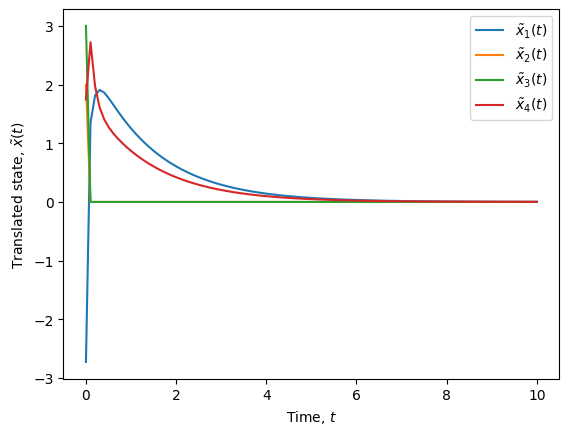

In [ ]:
# Set the translated initial conditions (this is step (6)):
x_tilde_01 = x01 - x1e  # translated state because the control library used here expects a system of the form x_dot = Ax, whereas equation (32) of Nersesov et al. is of the form x_dot = A(x - x_e)
x_tilde_02 = x02 - x2e
x_tilde_03 = x03 - x3e
x_tilde_04 = x04 - x4e

x_tilde_0 = np.array([[x_tilde_01],
              [x_tilde_02],
              [x_tilde_03],
              [x_tilde_04]])

print("x0 =", x0)
print("x_tilde_0 =", x_tilde_0)

# Control law:
S = ((R_2)**-1)*np.matmul(B, np.transpose(B)) #R_2 is 1x1 in this case because m = 1 (1 control input)
A_tilde = A - np.matmul(S, P) #from equation (32) of Nersesov et al. (v = I in the case of C = I_n).    NOTE: P is the solution of the algebraic Riccati equation
sys_closedLoop = ct.ss(A_tilde, np.zeros(B.shape), C, np.zeros(D.shape)) #create LTI system of closed loop, i.e., equation (32) of Nersesov et al.

# Simulate response of closed loop to initial conditions with translated states (this is step (7)):
SimulationTime = 10
TimeResponseData = ct.initial_response(sys_closedLoop, SimulationTime, x_tilde_0, return_x=True) # documentation: https://python-control.readthedocs.io/en/latest/generated/control.initial_response.html
plt.plot(TimeResponseData.time, TimeResponseData.states.T) # covergence to origin corresponds to convergence to x_e because x_tilde(t) = x(t) - x_e
plt.xlabel(r'Time, $t$')
plt.ylabel(r'Translated state, $\tilde{x}(t)$')
plt.legend([r'$\tilde{x}_1(t)$', r'$\tilde{x}_2(t)$', r'$\tilde{x}_3(t)$', r'$\tilde{x}_4(t)$'])

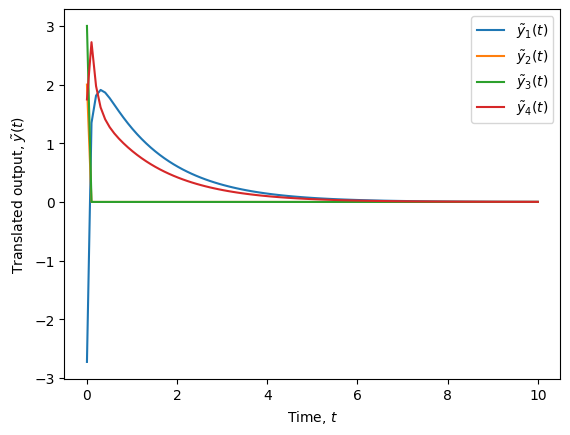

In [ ]:
# Plot y_tilde(t) = C*x_tilde(t), which must result equal to x_tilde(t) because C = I_n:

plt.plot(TimeResponseData.time, TimeResponseData.outputs.T)
plt.xlabel(r'Time, $t$')
plt.ylabel(r'Translated output, $\tilde{y}(t)$')
plt.legend([r'$\tilde{y}_1(t)$', r'$\tilde{y}_2(t)$', r'$\tilde{y}_3(t)$', r'$\tilde{y}_4(t)$'])

x0 = [[1]
 [2]
 [3]
 [4]]
xe = [[3.726812  ]
 [0.        ]
 [0.        ]
 [2.25343192]]


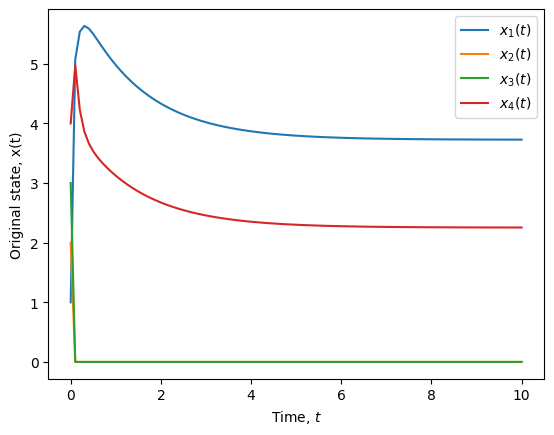

In [ ]:
# Recover and plot the original states, i.e., not translated (this is step (8)):
x_tilde = TimeResponseData.states

x1 = x_tilde[0] + x1e
x2 = x_tilde[1] + x2e
x3 = x_tilde[2] + x3e
x4 = x_tilde[3] + x4e
plt.plot(TimeResponseData.time, x1)
plt.plot(TimeResponseData.time, x2)
plt.plot(TimeResponseData.time, x3)
plt.plot(TimeResponseData.time, x4)
plt.xlabel(r'Time, $t$')
plt.ylabel('Original state, x(t)')
plt.legend([r'$x_1(t)$', '$x_2(t)$', '$x_3(t)$', '$x_4(t)$'])

print("x0 =", x0) # original initial conditions
print("xe =", xe)

/tmp/ipython-input-14-2615199552.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i] = sample_u


Text(0, 0.5, 'Control input, $u(t)$')

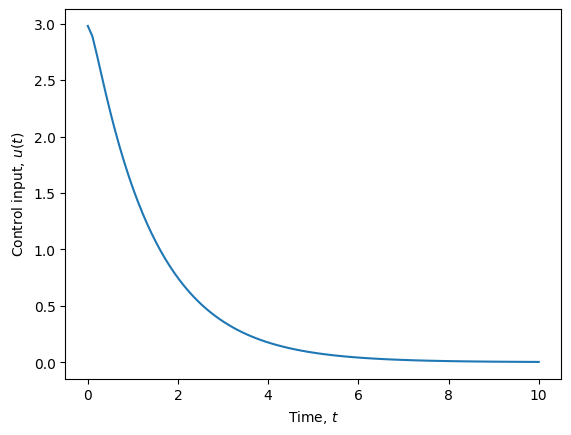

In [ ]:
# Plot u(t) = K*(y - C*x_e) + v_e (this is step (9)):
u = -1000*np.ones(len(TimeResponseData.time))
mat1 = np.matmul(C, xe)

for i in range(len(TimeResponseData.time)):
  # the library returns y_tilde = C*x_tilde, so you need to calculate y = C*x:
  x1_tilde_i = TimeResponseData.states[0,i]
  x2_tilde_i = TimeResponseData.states[1,i]
  x3_tilde_i = TimeResponseData.states[2,i]
  x4_tilde_i = TimeResponseData.states[3,i]
  x_tilde_i = np.array([[x1_tilde_i],
                 [x2_tilde_i],
                 [x3_tilde_i],
                 [x4_tilde_i]])
  yi = np.matmul(C, x_tilde_i + xe)
  mat2 = yi - mat1
  mat3 = np.matmul(K, mat2)
  sample_u = mat3 + v_e
  u[i] = sample_u

plt.plot(TimeResponseData.time, u)
plt.xlabel(r'Time, $t$')
plt.ylabel(r'Control input, $u(t)$')